In [2]:
%load_ext autoreload
%autoreload 2

import os, sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

PATH_TO_ROOT = '../..'
sys.path.insert(0, os.path.join(PATH_TO_ROOT, 'code', 'src'))
import utils, visualizations, analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
analysis_dir = os.path.join(PATH_TO_ROOT, 'analysis')
# analysis_dir = 'data/pilot_v3_11142024/min_time_1.3333/manual_0/groupings_absolute_study4'
# grouping_version = analysis_dir.split('groupings_')[1]

# Paths from dependent variables
# groupings_path = os.path.join(PATH_TO_ROOT, 'dependent_variables/groupings_colombatto_{}.json'.format(grouping_version))
categories_path = os.path.join(PATH_TO_ROOT, 'data', 'category_groupings.json')
items_path = os.path.join(PATH_TO_ROOT, 'data', 'mental_capacity_items.txt')

# Labels and colors for graphs
conditions = ['Baseline', 'Mechanistic', 'Functional', 'Intentional']
condition_color_idxs = [7, 1, 2, 4]
save_ext = 'pdf'

# Analysis dirs
categorization_source = 'body-heart-mind'
# R Results from 40-item survey
R_results_save_dir = os.path.join(analysis_dir, 'mental_capacities', categorization_source, 'R', 'results')
item_level_R_results_save_dir = os.path.join(analysis_dir, 'mental_capacities', 'item_level')
# Attitudes results
attitudes_R_results_save_dir = os.path.join(analysis_dir, 'attitudes', 'R', 'results')

# Save figure directories
fig_save_dir = os.path.join(analysis_dir, 'figures', 'cogsci')
utils.ensure_dir(fig_save_dir)

log_path = os.path.join(fig_save_dir, 'log.txt')
utils.informal_log("Analysis dir: {}".format(analysis_dir), log_path)
utils.informal_log("Fig dir: {}".format(fig_save_dir), log_path)

# # Mental state attribution save dir
# msa_graph_save_dir = os.path.join(PATH_TO_ROOT, fig_save_dir, 'msa_survey')
# utils.ensure_dir(msa_graph_save_dir)


[0426_093648] Analysis dir: ../../analysis
[0426_093648] Fig dir: ../../analysis/figures/cogsci


### Helper Functions

In [ ]:
# Helper Functions
def overall_pointplot(r_results_path,
                      grouping_source,
                      conditions,
                      emmeans_graph_save_dir,
                      condition_color_idxs,
                      orientation,
                      marker_size=6,
                      spacing_multiplier=0.1,
                      label=True,
                      show_xlabel=True,
                      show_ylabel=True,
                      show_legend=False,
                      title=None,
                      fig=None,
                      ax=None,
                      font_size_dict={},
                      save_path=None,
                      save_ext='pdf',
                      show=False):
    emmeans_graph_data, emmeans_df = analysis.read_emmeans_single_variable(
        results_path=r_results_path,
        grouping_source=grouping_source,
        variable_name='portrayal',
        variable_values=conditions,
        save_dir=emmeans_graph_save_dir,
        overwrite=False)

    emmeans_df = analysis._format_and_pivot_emmeans_df(
        emmeans_df=emmeans_df,
        target_column=None
    )

    # Extract means and CI errors
    means = emmeans_df['mean']
    means = [[mean] for mean in means]

    errors = emmeans_df['ci_error'].to_numpy()
    errors = [[error] for error in errors]

    if orientation == 'horizontal':
        ytick_labels = ['']
        if show_ylabel:
            ylabel = 'Overall Item Mean'
        else:
            ylabel = None
        xtick_labels = [i for i in range(1, 8)]
        if show_xlabel:
            xlabel = 'Rating (1-7)'
        else:
            xlabel=None
        fig_size = (7, 3)

    else:
        xtick_labels = ['Overall']
        if show_xlabel:
            if fig is None and ax is None:
                xlabel = 'Overall Item Mean'
            else:
                xlabel = 'Overall' # 'Overall\nItem Mean\n(a)'
        else:
            xlabel = None
        ytick_labels = [i for i in range(1, 8)]
        if show_ylabel:
            ylabel = 'Rating (1-7)'
        else:
            ylabel = None
        fig_size = (2, 4)
        xlim = (-1, 1)

    if label:
        labels = conditions
    else:
        labels = None

    fig, ax = visualizations.pointplot(
        fig=fig,
        ax=ax,
        means=means,
        errors=errors,
        orientation=orientation,
        labels=labels,
        show_legend=show_legend,
        ytick_labels=ytick_labels,
        yticks=ytick_labels,
        ylim=(0.5, 7.5),
        xtick_labels=xtick_labels,
        xlabel=xlabel,
        ylabel=ylabel,
        xlim=xlim,
        title=title,
        legend_loc='upper left',
        fig_size=fig_size,
        color_idxs=condition_color_idxs,
        marker_size=marker_size,
        show_grid=True,
        spacing_multiplier=spacing_multiplier,
        font_size_dict=font_size_dict,
        save_path=save_path,
        show=show)
    return fig, ax

def category_level_pointplot(r_results_path,
                      grouping_source,
                      groups,
                      conditions,
                      emmeans_graph_save_dir,
                      condition_color_idxs,
                      orientation,
                      show_xlabels,
                      show_ylabels,
                      marker_size,
                      label=False,
                      show_legend=True,
                      title=None,
                      fig=None,
                      ax=None,
                      font_size_dict={},
                      show=False,
                      save_path=None):
    emmeans_graph_data, emmeans_df = analysis.read_emmeans_marginalized_result(
        results_path=r_results_path,
        grouping_source=grouping_source,
        conditions=conditions,
        marginalized_var='category',
        marginalized_var_values=groups,
        save_dir=emmeans_graph_save_dir,
        overwrite=True
    )

    pivot_df = analysis._format_and_pivot_emmeans_df(
        emmeans_df=emmeans_df,
        target_column='category'
    )

    means = pivot_df[["mean-{}".format(condition) for condition in conditions]].to_numpy().T
    errors = pivot_df[["ci_error-{}".format(condition) for condition in conditions]].to_numpy().T

    if orientation == 'horizontal':
        if show_ylabels:
            ytick_labels = [label.capitalize() for label in pivot_df['category'].to_list()]
            ylabel = 'Item Categories'
        else:
            ytick_labels = None
            ylabel = None

        if show_xlabels:
            xtick_labels = [i for i in range(1, 8)]
            xlabel = 'Rating (1-7)'
        else:
            xtick_labels = None
            xlabel = None
        fig_size = (7, 3)

    else:
        xtick_labels = [label.capitalize() for label in pivot_df['category'].to_list()]
        if show_xlabels:
            if fig is None and ax is None:
                xlabel = 'Item Categories'
            else:
                xlabel = 'Item Categories\n(b)'
        else:
            xlabel = None

        if show_ylabels:
            ytick_labels = [i for i in range(1, 8)]
            ylabel = 'Rating (1-7)'
        else:
            ytick_labels = None
            ylabel = None

        fig_size = (3, 4)
        xlim = (-0.5, 2.5)
        # if grouping_source == 'body-heart-mind':
        #     xlim = (-0.5, 2.5)
        # else:
        #     xlim = (-0.5, 1.5)

    if label:
        labels = conditions
    else:
        labels = None

    fig, ax = visualizations.pointplot(
        fig=fig,
        ax=ax,
        means=means,
        errors=errors,
        orientation=orientation,
        labels=labels,
        show_legend=show_legend,
        ytick_labels=ytick_labels,
        yticks=ytick_labels,
        ylim=(0.5, 7.5),
        ylabel=ylabel,
        xtick_labels=xtick_labels,
        xlabel=xlabel,
        xlim=xlim,
        title=title,
        legend_loc='upper left',
        fig_size=fig_size,
        color_idxs=condition_color_idxs,
        marker_size=marker_size,
        font_size_dict=font_size_dict,
        show_grid=True,
        save_path=save_path,
        show=show)

    return fig, ax

### Graph ratings overall and using body-heart-mind categories

Saved file to ../../analysis/figures/cogsci/mca_overall_category/body-heart-mind.csv
[0426_093121] Saving graph to ../../analysis/figures/cogsci/mca_overall_category/overall-_body-heart-mind.pdf


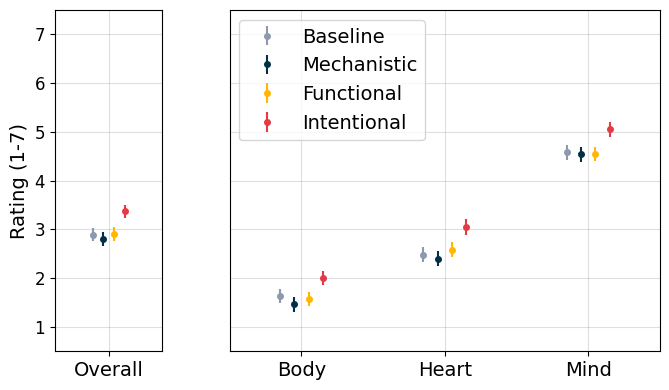

Error bars represent 95% Confidence Intervals


In [30]:
overall_category_save_dir = os.path.join(fig_save_dir, 'mca_overall_category')
utils.ensure_dir(overall_category_save_dir)

orientation = 'vertical'
marker_size = 4
save = True
font_size_dict = {
    'ylabel': 14,
    'legend': 14,
    'xticklabel': 14,
    'yticklabel': 12
}

R_results_path = os.path.join(R_results_save_dir, '{}_results.txt'.format(categorization_source))

categorization = utils.read_file(categories_path)[categorization_source]


# # groups = list(groupings[grouping_source].keys())

# r_results_path = r_results_path_template.format(grouping_source)
if not os.path.exists(R_results_path):
    raise ValueError("Path to R results file {} does not exist".format(R_results_path))

# Create fig with multiple subplots
fig, axes = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [1, 4]}, figsize=(6.8, 4))

# Right plot is means by category
fig, axes[1] = category_level_pointplot(
    r_results_path=R_results_path,
    grouping_source=categorization_source,
    groups=categorization.keys(),
    conditions=conditions,
    emmeans_graph_save_dir=overall_category_save_dir,
    condition_color_idxs=condition_color_idxs,
    orientation=orientation,
    marker_size=marker_size,
    show_xlabels=False,
    show_ylabels=False,
    label=True,
    show_legend=True,
    title=None,
    fig=fig,
    ax=axes[1],
    font_size_dict=font_size_dict,
    show=False,
    save_path=None)

# Left plot should be the overall means
fig, axes[0] = overall_pointplot(
    r_results_path=R_results_path,
    grouping_source=categorization_source,
    conditions=conditions,
    emmeans_graph_save_dir=overall_category_save_dir,
    condition_color_idxs=condition_color_idxs,
    orientation=orientation,
    marker_size=marker_size,
    spacing_multiplier=0.2,
    label=True,
    show_xlabel=False,
    show_ylabel=True,
    show_legend=False,
    title=None,
    fig=fig,
    ax=axes[0],
    font_size_dict=font_size_dict,
    save_path=None,
    show=False)

# fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4)
# fig.suptitle('Mean Mental State Attributions to LLMs')

plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
if save:
    fig_save_path = os.path.join(
        overall_category_save_dir,
        'overall-_{}.{}'.format(categorization_source, save_ext))
    utils.informal_log("Saving graph to {}".format(fig_save_path))
    plt.savefig(fig_save_path, bbox_inches="tight")
plt.show()
print("Error bars represent 95% Confidence Intervals")



## Item Level Point Plots

[0426_093711] Saving graph to ../../analysis/figures/cogsci/item_level/item_level_graph_separate.pdf


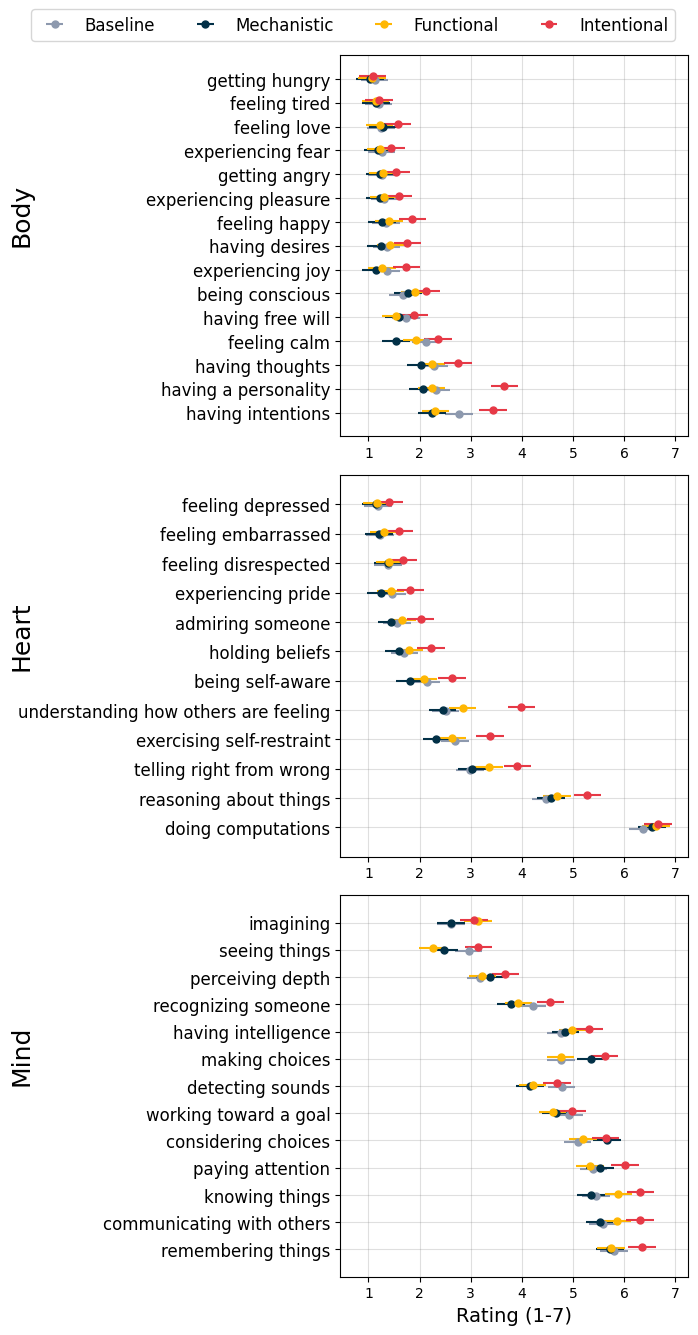

In [ ]:
item_level_save_dir = os.path.join(fig_save_dir, 'item_level')
utils.ensure_dir(item_level_save_dir)
save = True

item_level_R_results_path = os.path.join(item_level_R_results_save_dir, 'results.txt')
# category_r_results_path_template = os.path.join(
#     PATH_TO_ROOT, R_results_save_dir, '{}_results.txt')
# grouping_source = 'weisman'

# Read items and make R compatible
items = utils.read_file(items_path)
items = [item.replace(' ', '.') for item in items]


# Get ready to sort DF by group
categorization = utils.read_file(categories_path)[categorization_source]

# Create dictionary mapping item to its group
item_group_dict = {}
for k, vals in categorization.items():
    for val in vals:
        item_group_dict[val] = k
conditions = ["Baseline", "Mechanistic", "Functional", "Intentional"]

# Read item level emmeans
graph_data, df = analysis.read_emmeans_marginalized_result(
    results_path=item_level_R_results_path,
    grouping_source="item_level",
    marginalized_var='item',
    marginalized_var_values=items,
    save_dir=item_level_save_dir,
    overwrite=False
)

# Plot separate out by group
# print(groupings)
# print(df.head())

pivot_df = analysis._format_and_pivot_emmeans_df(
    emmeans_df=df,
    target_column='item'
)

pivot_df['category'] = pivot_df['item'].apply(lambda x : item_group_dict[x])

categories = categorization.keys()

# Parameters for plotting
font_size_dict = {
    'xlabel': 14,
    'ylabel': 18,
    'legend': 12,
    'title': 14,
    'xticklabel': 10,
    'yticklabel': 12
}
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(7, 13))

for idx, category in enumerate(categories):
    category_df = pivot_df[pivot_df['category'] == category]
    category_df = category_df.sort_values(by=['mean-Baseline'], ascending=False)

    # Extract means and 95% CI errors
    means = category_df[["mean-{}".format(condition) for condition in conditions]].to_numpy().T
    errors = category_df[["ci_error-{}".format(condition) for condition in conditions]].to_numpy().T

    ylim = (-1, len(category_df))
    ytick_labels_list = category_df['item'].to_list()

    fig, axes[idx] = visualizations.pointplot(
        fig=fig,
        ax=axes[idx],
        means=means,
        errors=errors,
        orientation='horizontal',
        labels=conditions if idx == 0 else None,
        show_legend=False,
        ytick_labels=ytick_labels_list,
        xtick_labels=[i for i in range(1, 8)],
        xlabel='Rating (1-7)' if idx == len(categories) - 1 else "",
        ylabel=category.capitalize(),
        ylim=ylim,
        show_grid=True,
        alpha=1.0,
        marker_size=5,
        color_idxs=condition_color_idxs,
        font_size_dict=font_size_dict,
    )

    # Align y-axis label to be the same
    label_x_pos = -0.88
    axes[idx].yaxis.set_label_coords(label_x_pos, 0.58)

    # enable xticks
    axes[idx].tick_params(labelbottom=True)


# Add legend to top
fig.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.03),
    ncol=4,
    fontsize=font_size_dict['legend'] if 'legend' in font_size_dict else None)

if save:
    save_path = os.path.join(item_level_save_dir, 'item_level_graph.{}'.format(save_ext))
    utils.informal_log("Saving graph to {}".format(save_path))
    plt.savefig(save_path, bbox_inches="tight")
plt.show()



## Plot attitudes

Note: in Cogsci version, we only reported anthropomorphism

[0426_094443] Saving graph to ../../analysis/figures/cogsci/attitudes/attitudes_graph.pdf


<Figure size 640x480 with 0 Axes>

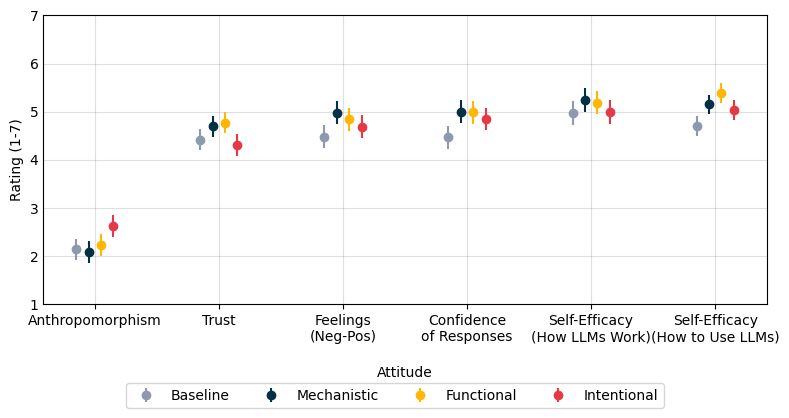

In [40]:
attitudes_save_dir = os.path.join(fig_save_dir, 'attitudes')
utils.ensure_dir(attitudes_save_dir)

# plot_type = 'pointplot'
# letter_labels = True

attitude_labels = {
    'humanness': 'Anthropomorphism',
    'trust': 'Trust',
    'feeling': 'Feelings\n(Neg-Pos)',
    'confidence': 'Confidence\nof Responses',
    'se_how': 'Self-Efficacy\n(How LLMs Work)\n ',
    'se_use': 'Self-Efficacy\n(How to Use LLMs)'
}
# if not letter_labels:
#     attitude_labels = {
#         'anthro': 'Anthropomorphism',
#         'trust': 'Trust',
#         'general': 'Feelings\n(Neg-Pos)',
#         'confidence': 'Confidence\nof Responses',
#         'se_how': 'Self-Efficacy\n(How LLMs Work)\n ',
#         'se_use': 'Self-Efficacy\n(How to Use LLMs)'
#     }
# else:
#     attitude_labels = {
#         'anthro': 'Anthro-\npomorphism\n\n(a)',
#         'trust': 'Trust\n\n\n(b)',
#         'general': 'General\nAttitude\n\n(c)',
#         'confidence': 'Confidence\nof Responses\n\n(d)',
#         'se_how': 'Self-Efficacy\n(How LLMs Work)\n\n(e)\n',
#         'se_use': 'Self-Efficacy\n(How to\nUse LLMs)\n(f)',

#         }


attitudes = attitude_labels.keys()

means = []
errors = []

for attitude in attitudes:
    results_path = os.path.join(attitudes_R_results_save_dir, '{}_results.txt'.format(attitude))

    graph_data, emmeans_df = analysis.read_emmeans_single_variable(
        results_path=results_path,
        grouping_source=attitude,
        variable_name='portrayal'
    )

    attitude_means = list(np.array(graph_data['means']).squeeze())
    attitude_errors = list(np.array(graph_data['errors']).squeeze())
    means.append(attitude_means)
    errors.append(attitude_errors)

means = np.array(means).T
errors = np.array(errors).T
fig, ax = visualizations.pointplot(
    means=means,
    errors=errors,
    color_idxs=condition_color_idxs,
    labels=conditions,
    show_legend=False,
    orientation='vertical',
    xlabel='Attitude',
    xtick_labels=[attitude_labels[attitude] for attitude in attitudes],
    ylim=[1, 7],
    ylabel='Rating (1-7)',
    # title='Mean Ratings of Additional Beliefs Across Conditions',
    show_grid=True,
    fig_size=(8, 4),
    show=False
)
# Add Legend outside of plot
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4)
plt.tight_layout()

save_path = os.path.join(attitudes_save_dir, 'attitudes_graph.{}'.format(save_ext))
utils.informal_log("Saving graph to {}".format(save_path))

plt.savefig(save_path, bbox_inches='tight')
plt.show()

